In [1]:
import pandas as pd
import pandas as pd
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

In [2]:
dataset = tf.keras.utils.get_file("train.csv", "https://storage.googleapis.com/tf-datasets/titanic/train.csv")

# Read the dataset into a Pandas DataFrame
TITANIC = pd.read_csv(dataset)

In [3]:
import sys
sys.path.append('..')
from xDL.models.NATT import NATT

In [4]:
model = NATT(
    "survived ~  -1 + MLP(fare) +  MLP(age) + Transformer(sex):Transformer(deck)", 
    data=TITANIC, 
    feature_dropout=0.0001,
    binning_task="regression"
    )

--- Preprocessing ---


5it [00:00,  5.12it/s]
4it [00:00, 255.87it/s]


------------- Network architecture --------------
Transformer -> (ListWrapper(['sex', 'deck']), dims=32, depth=4, heads=8) -> MLP(input_dim=64) -> output dimension=1
fare -> MLP(feature=fare, n_params=12736) -> output dimension=1
age -> MLP(feature=age, n_params=12736) -> output dimension=1


In [5]:
optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.BinaryCrossentropy(), "importances": None, "att_weights": None},
    metrics= {"output": [tf.keras.metrics.AUC(name="PR AUC", curve='PR'), tf.keras.metrics.AUC(name="auc")], "importances": None, "att_weights": None},)

history = model.fit(
    model.training_dataset, 
    epochs=20, 
    validation_data=model.validation_dataset,
    verbose=1
)

Epoch 1/20
1/1 [==============================] - 13s 13s/step - loss: 5.5284 - output_loss: 5.5284 - output_PR AUC: 0.3971 - output_auc: 0.5031 - val_loss: 6.0358 - val_output_loss: 6.0358 - val_output_PR AUC: 0.4498 - val_output_auc: 0.5080
Epoch 2/20
1/1 [==============================] - 0s 127ms/step - loss: 5.2649 - output_loss: 5.2649 - output_PR AUC: 0.4607 - output_auc: 0.5305 - val_loss: 3.6638 - val_output_loss: 3.6638 - val_output_PR AUC: 0.5047 - val_output_auc: 0.5488
Epoch 3/20
1/1 [==============================] - 0s 111ms/step - loss: 4.9132 - output_loss: 4.9132 - output_PR AUC: 0.4446 - output_auc: 0.5190 - val_loss: 3.3370 - val_output_loss: 3.3370 - val_output_PR AUC: 0.3824 - val_output_auc: 0.4614
Epoch 4/20
1/1 [==============================] - 0s 110ms/step - loss: 4.6223 - output_loss: 4.6223 - output_PR AUC: 0.4022 - output_auc: 0.4938 - val_loss: 2.3250 - val_output_loss: 2.3250 - val_output_PR AUC: 0.4741 - val_output_auc: 0.5315
Epoch 5/20
1/1 [=========

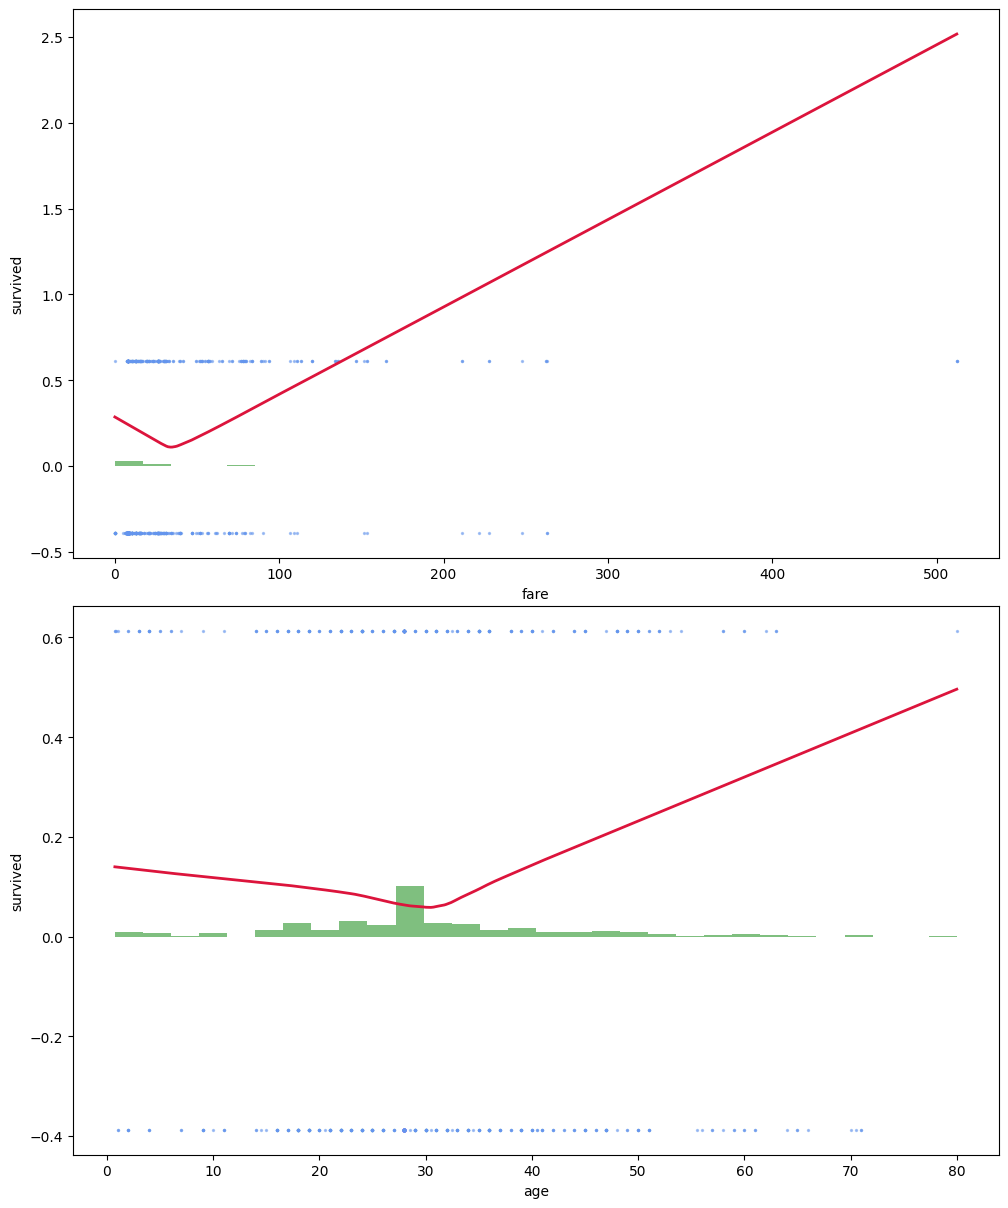

In [6]:
model.plot()

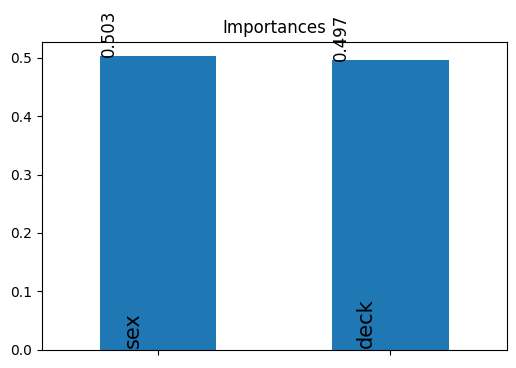

In [7]:
model.plot_importances()

In [16]:
dataset = model._get_dataset(model.data, shuffle=False)
importances = model.predict(dataset, verbose=0)["importances"]

column_list = []
for i, feature in enumerate(model.TRANSFORMER_FEATURES):
    column_list.extend([feature] * model.inputs[feature].shape[1])

importances = pd.DataFrame(importances[:, 1:], columns=column_list)

--- Preprocessing ---


0it [00:00, ?it/s]

5it [00:00,  8.01it/s]


In [17]:
import numpy as np
import matplotlib.pyplot as plt

average_importances = []
for col_name in model.TRANSFORMER_FEATURES:
    average_importances.append(importances.filter(like=col_name).sum(axis=1))
importances = pd.DataFrame(
    {
        column_name: column_data
        for column_name, column_data in zip(
            model.TRANSFORMER_FEATURES, average_importances
        )
    }
)
importances

,sex,deck
0,0.331507,0.328379
1,0.333022,0.330124
2,0.334984,0.326066
3,0.333022,0.330124
4,0.331507,0.328379
...,...,...
622,0.331507,0.328379
623,0.331507,0.328379
624,0.332152,0.332104
625,0.334984,0.326066


In [21]:
result_dict = {}
imps_sorted = importances.mean().sort_values(ascending=False)
for category in model.TRANSFORMER_FEATURES:
    print(category)
    unique_vals = model.data[category].unique()
    print(unique_vals)
    for val in unique_vals:
        bsc = model.data[model.data[category] == val].index
        imps_value = importances.loc[bsc.values][category].mean()
        result_dict[val] = imps_value
sort_dict = dict(sorted(result_dict.items(), key=lambda item: item[1]))
sorted_df = pd.DataFrame([sort_dict])


sex
['male' 'female']
deck
['unknown' 'C' 'G' 'A' 'B' 'D' 'F' 'E']


--- Preprocessing ---


5it [00:00,  9.81it/s]


<Figure size 1200x400 with 0 Axes>

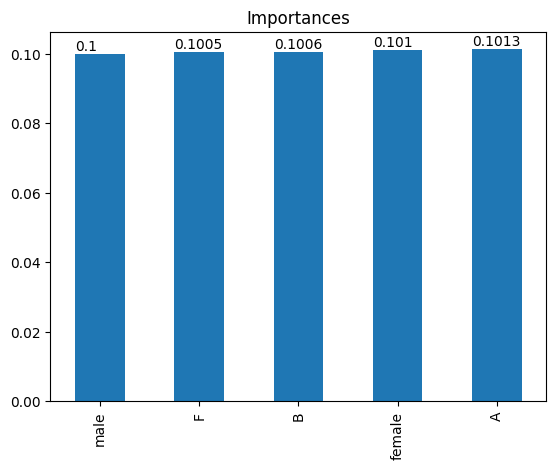

In [14]:
model.plot_categorical_importances()

--- Preprocessing ---


0it [00:00, ?it/s]

5it [00:00,  5.84it/s]


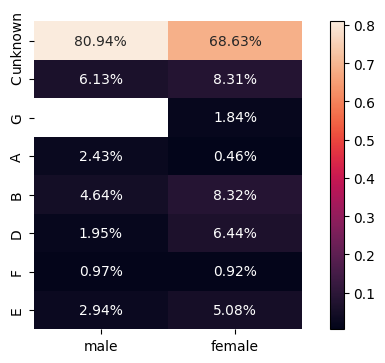

In [9]:
model.plot_heatmap_importances("sex", "deck")

--- Preprocessing ---


0it [00:00, ?it/s]

5it [00:01,  4.50it/s]


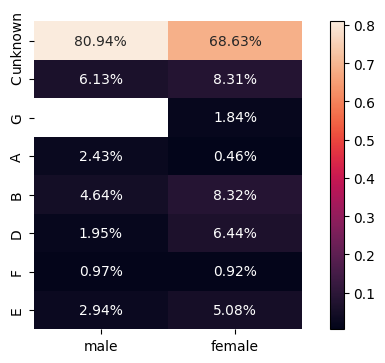

In [10]:
model.plot_heatmap_importances("sex", "deck")

# test continuous feature interactions

In [11]:
model = NATT(
    "survived ~  -1 + MLP(fare):MLP(age) + Transformer(sex):Transformer(deck):Transformer(embark_town)",
    data=TITANIC, 
    feature_dropout=0.0001)

--- Preprocessing ---


0it [00:00, ?it/s]

6it [00:01,  4.79it/s]
5it [00:00, 1483.13it/s]


------------- Network architecture --------------
Transformer -> (ListWrapper(['sex', 'deck', 'embark_town']), dims=32, depth=4, heads=8) -> MLP(input_dim=96) -> output dimension=1
fare_._age -> MLP(feature=fare_._age, n_params=12864) -> output dimension=1


In [12]:
optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.BinaryCrossentropy(), "importances": None, "att_weights": None},
    metrics= {"output": [tf.keras.metrics.AUC(name="PR AUC", curve='PR'), "accuracy"], "importances": None, "att_weights": None},)

history = model.fit(
    model.training_dataset, 
    epochs=30, 
    validation_data=model.validation_dataset,
    verbose=1
)

Epoch 1/30


1/1 [==============================] - 14s 14s/step - loss: 2.4168 - output_loss: 2.4168 - output_PR AUC: 0.4449 - output_accuracy: 0.6474 - val_loss: 1.2226 - val_output_loss: 1.2226 - val_output_PR AUC: 0.3513 - val_output_accuracy: 0.6080
Epoch 2/30
1/1 [==============================] - 0s 203ms/step - loss: 2.3220 - output_loss: 2.3220 - output_PR AUC: 0.4395 - output_accuracy: 0.6076 - val_loss: 0.9524 - val_output_loss: 0.9524 - val_output_PR AUC: 0.4126 - val_output_accuracy: 0.6240
Epoch 3/30
1/1 [==============================] - 0s 190ms/step - loss: 2.2798 - output_loss: 2.2798 - output_PR AUC: 0.4357 - output_accuracy: 0.6235 - val_loss: 0.8462 - val_output_loss: 0.8462 - val_output_PR AUC: 0.4648 - val_output_accuracy: 0.6400
Epoch 4/30
1/1 [==============================] - 0s 216ms/step - loss: 1.9391 - output_loss: 1.9391 - output_PR AUC: 0.4088 - output_accuracy: 0.6076 - val_loss: 0.9039 - val_output_loss: 0.9039 - val_output_PR AUC: 0.4938 - val_output_accuracy: 0.5

In [13]:
model.feature_nets

ListWrapper([<keras.src.engine.functional.Functional object at 0x000001B7B6E0ED10>])

100/100 [==============================] - 0s 2ms/step


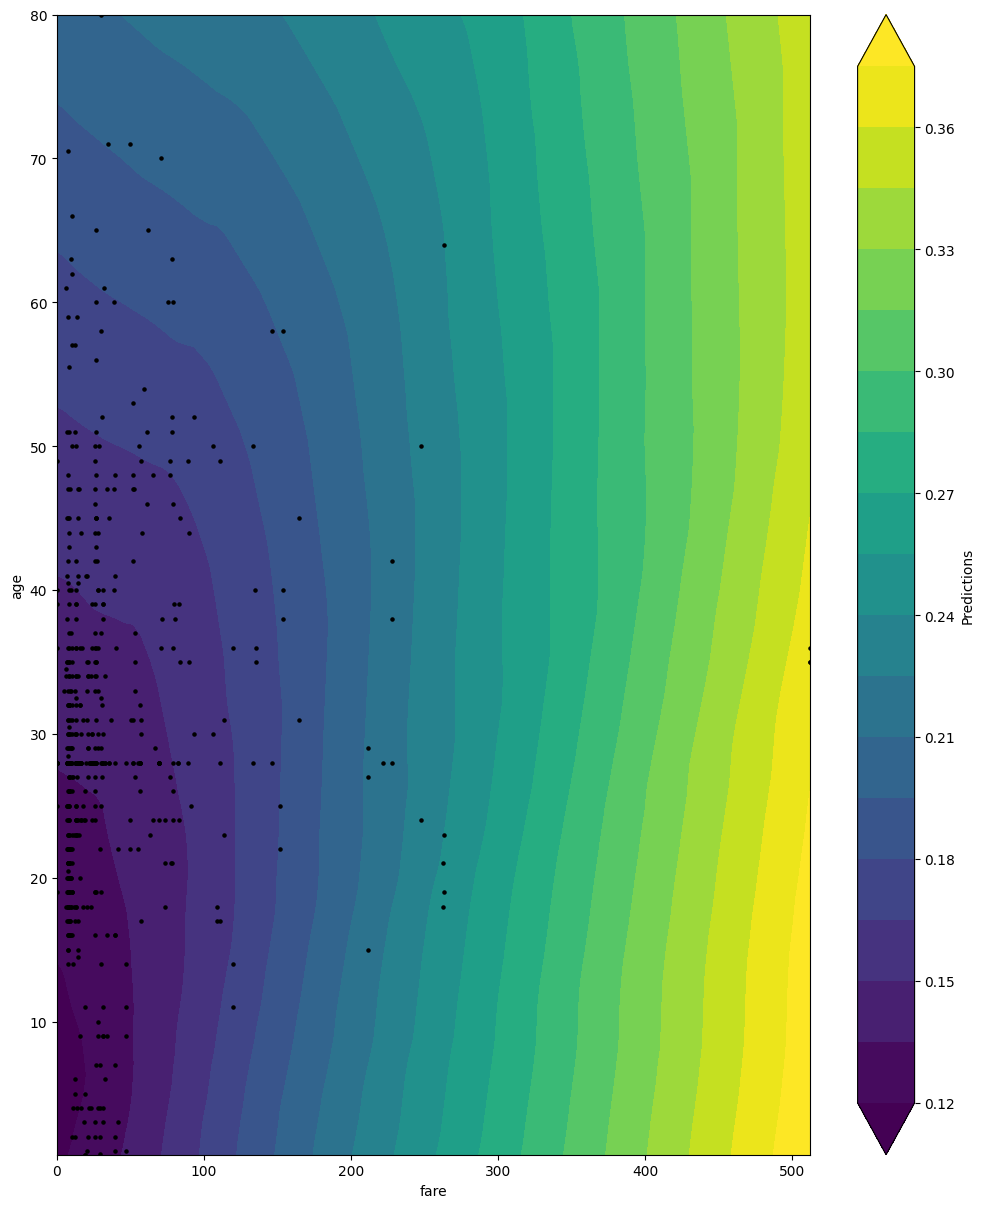

In [14]:
model.plot()